<a href="https://colab.research.google.com/github/rimbourouphael/NSY107/blob/main/Models_Comparison_Balanced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Models Comparison


#### Balanced Dataset

In [ ]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 5.9 MB/s 


In [ ]:
import numpy as np
SEED = 137
np.random.seed(SEED)

import time
from collections import Counter

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import decomposition

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
torch.manual_seed(SEED)
import torch.nn as nn
import torch.nn.functional as F

from skorch.classifier import NeuralNetBinaryClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot

### Data Preprocessing

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rimbourouphael/NSY107/main/dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


In [ ]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(int)
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [ ]:
print(X.min())
print(X.max())

0
306


In [ ]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [ ]:
check_imbalance(y)

[(0, 1079), (1, 42797)]
39.66357738646895


In [ ]:
random_undersampler = RandomUnderSampler(random_state = SEED)

X, y = random_undersampler.fit_resample(X, y)

check_imbalance(y)

[(0, 1079), (1, 1079)]
1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [ ]:
check_imbalance(y_train)
check_imbalance(y_test)

del df, X, y

[(0, 738), (1, 772)]
1.046070460704607
[(0, 341), (1, 307)]
0.9002932551319648


### Models

#### DGCNN

In [ ]:
def norn_adj(X, input_dim_1):
    
    A = torch.zeros((X.size(0), input_dim_1, input_dim_1), dtype = torch.float).cuda()
        
    A_view = A.view(A.size(0), -1)
    x_size = X.size(-1)
    indices = X.narrow(-1, 0, x_size - 1) * A.stride(1) * A.stride(2) + X.narrow(-1, 1, x_size - 1) * A.stride(2)
    A_view.scatter_(1, indices, 1)
        
    A_hat = A + torch.eye(input_dim_1, dtype = torch.float).cuda()
    D_hat = A_hat.sum(dim = 1).pow(-1.0).diag_embed()
    
    return A_hat, D_hat

def to_one_hot(X, input_dim_1):
    
    X = F.one_hot(X, num_classes = input_dim_1).float()    
    X = X.permute(0, 2, 1)
    
    return X

class DGCNN_network(nn.Module):
    
    def __init__(self, weight_dim_1, weight_dim_2):

        super(DGCNN_network, self).__init__()
        self.weight_dim_1 = weight_dim_1
        self.weight_dim_2 = weight_dim_2        
        self.weights = nn.Parameter(torch.rand((self.weight_dim_1, weight_dim_2), dtype = torch.float, requires_grad = True))
        
    def forward(self, A_hat, D_hat, X):
        return D_hat.matmul(A_hat).matmul(X).matmul(self.weights)

#### Model-1

In [ ]:
H_list_model_1 = []

class Model_1_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, dropout_rate):
        
        super(Model_1_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.dropout_rate = dropout_rate
        
        self.dgcnn = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.input_dim_1 * self.weight_dim_2, 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)

        H = self.dgcnn(A_hat, D_hat, X)
        H = self.dropout(H)
        H = torch.relu(H)
        H = H.view(H.size(0), -1)
        
        # Visualization
        if not self.training:
            H_list_model_1.append(H.cpu())        
        
        H = self.fc(H)
                
        return H.squeeze()

#### Model-2

In [ ]:
H_list_model_2 = []

class Model_2_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, weight_dim_4, dropout_rate):
    
        super(Model_2_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.weight_dim_3 = weight_dim_2
        self.weight_dim_4 = weight_dim_4
        self.dropout_rate = dropout_rate
        
        self.dgcnn_1 = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.dgcnn_2 = DGCNN_network(self.weight_dim_3, self.weight_dim_4)
        self.fc = nn.Linear(self.input_dim_1 * (self.weight_dim_2 + self.weight_dim_4), 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)        

        H_1 = self.dgcnn_1(A_hat, D_hat, X)
        H_1 = self.dropout(H_1)
        H_1 = torch.relu(H_1)
        H_2 = self.dgcnn_2(A_hat, D_hat, H_1)
        H_2 = self.dropout(H_2)
        H_2 = torch.relu(H_2)
        H_2 = torch.cat([H_1, H_2], 2)
        H_2 = H_2.view(H_2.size(0), -1)

        # Visualization
        if not self.training:
            H_list_model_2.append(H_2)   
        
        H_2 = self.fc(H_2)
                
        return H_2.squeeze()

#### LSTM

In [ ]:
H_list_lstm = []

class LSTM_network(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        
        super(LSTM_network, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first = True)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.hidden_dim, 1)
        
    def forward(self, X):
        
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()
        
        # Hidden layer shape: (num_layers, batch_size, hidden_dim)
        hidden_0 = (torch.zeros(1, X.size(0), self.hidden_dim).float().cuda(),
                    torch.zeros(1, X.size(0), self.hidden_dim).float().cuda())
        
        # Input/Output shape: (batch_size, seq_len, input_dim)
        _, self.hidden = self.lstm(X, hidden_0)
                
        H = self.hidden[0].squeeze()
        H = self.dropout(H)
        
        # Visualization
        if not self.training:
            H_list_lstm.append(H)           
        
        H = self.fc(H)
                
        return H.squeeze()

### Evaluation

In [ ]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y >= 0.5, pred >= 0.5))
    print(f'Accuracy: {accuracy_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'Precision: {precision_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'Recall: {recall_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'F1-Score: {f1_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'ROC AUC: {roc_auc_score(y, pred):.4f}')
    return

#### LSTM

In [ ]:
torch.manual_seed(SEED)

input_dim = 307
hidden_dim = 10
dropout_rate = 0.4
batch_size = 32
max_epochs = 30

LSTM = NeuralNetBinaryClassifier(
    LSTM_network,
    module__input_dim = input_dim,
    module__hidden_dim = hidden_dim,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', LSTM)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6375  0.2912
      2        0.4992  0.2442
      3        0.4429  0.2267
      4        0.3841  0.2281
      5        0.3472  0.2365
      6        0.3430  0.2313
      7        0.3276  0.2332
      8        0.2930  0.2279
      9        0.2713  0.2228
     10        0.2465  0.2340
     11        0.2506  0.2316
     12        0.2339  0.2290
     13        0.2135  0.2372
     14        0.2005  0.2292
     15        0.2538  0.2338
     16        0.2314  0.2196
     17        0.1983  0.2290
     18        0.1773  0.2233
     19        0.1519  0.2263
     20        0.1398  0.2296
     21        0.1226  0.2268
     22        0.1997  0.2310
     23        0.2163  0.2327
     24        0.1494  0.2278
     25        0.1211  0.2254
     26        0.1205  0.2300
     27        0.0936  0.2237
     28        0.1026  0.2242
     29        0.1076  0.2264
     30        0.1030  0.2225


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=LSTM_network(
    (lstm): LSTM(307, 10, batch_first=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc): Linear(in_features=10, out_features=1, bias=True)
  ),
))])

In [ ]:
H_list_lstm.clear()

X_test_predictions_1 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))

X_test_predictions_11 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, X_test_predictions_11)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[306  35]
 [ 44 263]]
Accuracy: 0.8781
Precision: 0.8826
Recall: 0.8567
F1-Score: 0.8694
ROC AUC: 0.9449


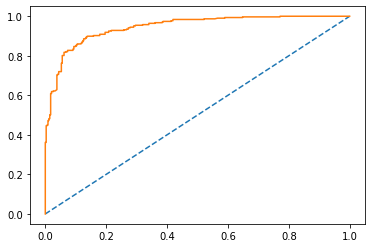

In [ ]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, X_test_predictions_11)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_1, tpr_1)
pyplot.show()

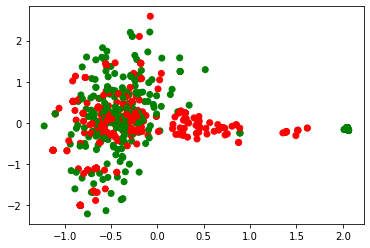

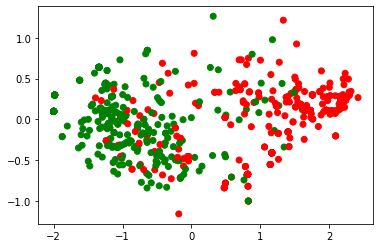

In [ ]:
# visualize_pca(X_test, y_test)

X = X_test / np.max(X_test)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])
plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_1.pdf')
plt.show()

result = torch.zeros(1, 10)

for i in H_list_lstm:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]

X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_2.pdf')
plt.show()

#### Model-1

In [ ]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 31
dropout_rate = 0.6
batch_size = 32
max_epochs = 30

model_1 = NeuralNetBinaryClassifier(
    Model_1_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_1)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1        1.2049  0.3445
      2        0.6514  0.3397
      3        0.3855  0.3364
      4        0.2508  0.3612
      5        0.2185  0.3598
      6        0.1572  0.3594
      7        0.1389  0.3486
      8        0.1280  0.3505
      9        0.1245  0.3422
     10        0.0968  0.3554
     11        0.0952  0.3551
     12        0.0943  0.3468
     13        0.0772  0.3500
     14        0.0786  0.3561
     15        0.0756  0.3553
     16        0.0569  0.3496
     17        0.0740  0.3563
     18        0.0580  0.3501
     19        0.0676  0.3522
     20        0.0506  0.3604
     21        0.0506  0.3545
     22        0.0567  0.3542
     23        0.0477  0.3639
     24        0.0399  0.3695
     25        0.0499  0.3712
     26        0.0465  0.3679
     27        0.0344  0.3733
     28        0.0384  0.3815
     29        0.0403  0.3819
     30        0.0421  0.3742


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_1_network(
    (dgcnn): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=9517, out_features=1, bias=True)
  ),
))])

In [ ]:
H_list_model_1.clear()

X_test_predictions_2 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))
X_test_predictions_22 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, X_test_predictions_22)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[321  20]
 [ 30 277]]
Accuracy: 0.9228
Precision: 0.9327
Recall: 0.9023
F1-Score: 0.9172
ROC AUC: 0.9730


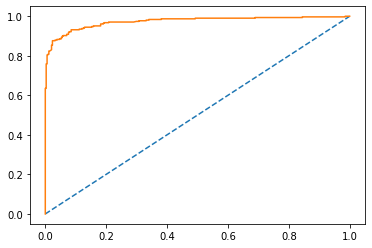

In [ ]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, X_test_predictions_22)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_2, tpr_2)
pyplot.show()

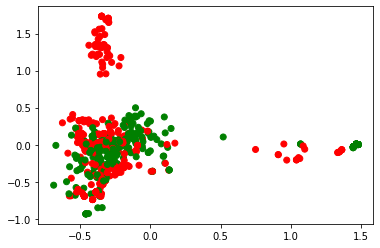

In [ ]:
result = torch.zeros(1, 9517)

for i in H_list_model_1:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]

X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_3.pdf')
plt.show()

#### Model-2

In [ ]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 71
weight_dim_4 = 17
dropout_rate = 0.6
batch_size = 32
max_epochs = 30

model_2 = NeuralNetBinaryClassifier(
    Model_2_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__weight_dim_4 = weight_dim_4,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_2)
])

pipe.fit(X_train, y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  epoch    train_loss     dur
-------  ------------  ------
      1       17.7610  0.4170
      2        3.0380  0.3784
      3        0.6344  0.3512
      4        0.2701  0.3476
      5        0.1933  0.3397
      6        0.1601  0.3407
      7        0.1355  0.3445
      8        0.1150  0.3412
      9        0.1170  0.3466
     10        0.0815  0.3413
     11        0.0832  0.3467
     12        0.0730  0.3461
     13        0.0676  0.3496
     14        0.0664  0.3417
     15        0.0683  0.3449
     16        0.0539  0.3489
     17        0.0607  0.3430
     18        0.0383  0.3408
     19        0.0365  0.3467
     20        0.0394  0.3424
     21        0.0462  0.3432
     22        0.0477  0.3456
     23        0.0314  0.3463
     24        0.0351  0.3405
     25        0.0384  0.3487
     26        0.0254  0.3441
     27        0.0279  0.3347
     28        0.0334  0.3438
     29        0.0259  0.3419
     30        0.0291  0.3430


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_2_network(
    (dgcnn_1): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (dgcnn_2): DGCNN_network()
    (fc): Linear(in_features=27016, out_features=1, bias=True)
  ),
))])

In [ ]:
H_list_model_2.clear()

X_test_predictions_3 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))
X_test_predictions_33 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, X_test_predictions_33)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[312  29]
 [ 21 286]]
Accuracy: 0.9228
Precision: 0.9079
Recall: 0.9316
F1-Score: 0.9196
ROC AUC: 0.9687


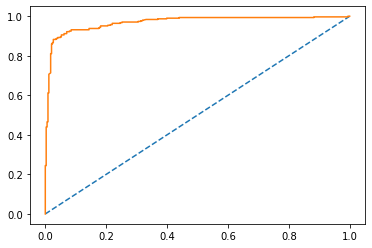

In [ ]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, X_test_predictions_33)
pyplot.plot([0, 1], [0, 1], linestyle = '--')
pyplot.plot(fpr_3, tpr_3)
pyplot.show()

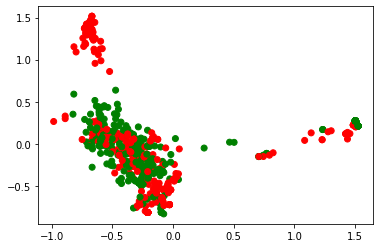

In [ ]:
result = torch.zeros(1, 27016)

for i in H_list_model_2:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]


X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
#points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_4.pdf')
plt.show()

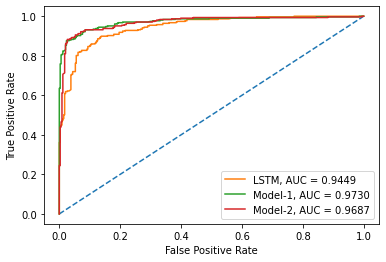

In [ ]:
pyplot.plot([0, 1], [0, 1], linestyle = '--')
auc_1 = roc_auc_score(y_test, X_test_predictions_11)
pyplot.plot(fpr_1, tpr_1, label = f'LSTM, AUC = {auc_1:.4f}')
auc_2 = roc_auc_score(y_test, X_test_predictions_22)
pyplot.plot(fpr_2, tpr_2, label = f'Model-1, AUC = {auc_2:.4f}')
auc_3 = roc_auc_score(y_test, X_test_predictions_33)
pyplot.plot(fpr_3, tpr_3, label = f'Model-2, AUC = {auc_3:.4f}')
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_b.pdf')
pyplot.show()